## Code Completion System

This is a JavaScript Code Prediction System（with Huge dataset)

In [5]:
import pickle
repre_matrix_dir = 'temp_info/token2vec_repre_matrix.p'
def get_represent_matrix():
    file = open(repre_matrix_dir, 'rb')
    nt_matrix, tt_matrix = pickle.load(file)
    return nt_matrix, tt_matrix


In [15]:
a, b = get_represent_matrix()
print(type(a))

<class 'numpy.ndarray'>


In [12]:
import numpy as np
a = np.array(a)
b = np.array(b)

In [13]:
print(type(a))

<class 'numpy.ndarray'>


In [14]:
file = open(repre_matrix_dir, 'wb')
pickle.dump([a ,b], file)

In [11]:
print(len(b))

30001


In [9]:
for i in range(10):
    print(len(a[i]))

300
300
300
300
300
300
300
300
300
300


In [17]:


terminal_count = Counter()  # 统计每个terminal token的出现次数
non_terminal_set = set()  # 统计non_termial token 种类


def ast_to_seq(binary_tree, run_or_process='process'):
    # 将一个ast首先转换成二叉树，然后对该二叉树进行中序遍历，得到nt_sequence
    temp_terminal_count = Counter()
    temp_non_terminal_set = set()
    def node_to_string(node):
        # 将一个node转换为string
        if node == 'EMPTY':
            string_node = 'EMPTY'
            temp_terminal_count[string_node] += 1
        elif node['isTerminal']:  # 如果node为terminal
            string_node = str(node['type'])
            if 'value' in node.keys():
                # Note:There are some tokens(like:break .etc）do not contains 'value'
                string_node += '=$$=' + str(node['value'])
            temp_terminal_count[string_node] += 1

        else:  # 如果是non-terminal

            string_node = str(node['type']) + '=$$=' + \
                str(node['hasSibling']) + '=$$=' + \
                str(node['hasNonTerminalChild'])  # 有些non-terminal包含value，探索该value的意义？（value种类非常多）
            temp_non_terminal_set.add(string_node)

        return string_node

    def in_order_traversal(bin_tree, index):
        # 对给定的二叉树进行中序遍历，并在中序遍历的时候，生成nt_pair
        node = bin_tree[index]
        if 'left' in node.keys():
            in_order_traversal(bin_tree, node['left'])

        if node == 'EMPTY' or node['isTerminal'] is True:  # 该token是terminal，只将其记录到counter中
            node_to_string(node)
        else:
            assert 'isTerminal' in node.keys() and node['isTerminal'] is False
            # 如果该node是non-terminal，并且包含一个terminal 子节点，则和该子节点组成nt_pair保存在output中
            # 否则将nt_pair的T设为字符串EMPTY
            n_pair = node_to_string(node)
            for child_index in node['children']:  # 遍历该non-terminal的所有child，分别用所有child构建NT-pair
                if bin_tree[child_index]['isTerminal']:
                    t_pair = node_to_string(bin_tree[child_index])
                else:
                    t_pair = node_to_string('EMPTY')
                nt_pair = (n_pair, t_pair)
                output.append(nt_pair)


        if node['right'] != -1:  # 遍历right side
            in_order_traversal(bin_tree, node['right'])

    output = []
    in_order_traversal(binary_tree, 0)

    if run_or_process == 'run':
        return output

    if len(output) >= time_steps:  # note: 仅将长度大于阈值的ast产生的node统计到counter中
        terminal_count.update(temp_terminal_count)
        non_terminal_set.update(temp_non_terminal_set)
    else:
        output = []
    return output

NameError: name 'Counter' is not defined

In [16]:
import subprocess
import json
import utils

def code_to_ast(code_path='js_parser/js_helloworld.js'):
    out_bytes = subprocess.check_output('node js_parser/js_parser.js ' + code_path, shell=True)
    out_text = out_bytes.decode('utf-8')
    ast = json.loads(out_text)
    binary_tree = utils.bulid_binary_tree(ast)
    nt_seq = utils.ast_to_seq(binary_tree, run_or_process='run')
    print(nt_seq)
    
    
code_to_ast()

TypeError: ast_to_seq() got an unexpected keyword argument 'run_or_process'

In [ ]:
import tensorflow as tf
import numpy as np
import time
import pickle
from collections import Counter

import utils
from basic_lstm import RnnModel
from setting import Setting


test_setting = Setting()
test_subset_data_dir = test_setting.sub_int_test_dir
model_save_dir = test_setting.lstm_model_save_dir
test_log_dir = test_setting.lstm_test_log_dir


num_subset_test_data = test_setting.num_sub_test_data
seq_per_subset = 5000
show_every_n = test_setting.test_show
num_terminal = test_setting.num_terminal
test_time_step = 50

In [ ]:
class ShortLongTest(object):
    """Record the performance with different length"""
    def __init__(self,
                 num_ntoken,
                 num_ttoken,):
        self.model = RnnModel(num_ntoken, num_ttoken, is_training=False)
        self.sess = tf.Session()
        self.last_chackpoints = tf.train.latest_checkpoint(
            checkpoint_dir=model_save_dir)

        saver = tf.train.Saver()
        saver.restore(self.sess, self.last_chackpoints)

    def subset_generator(self):
        for index in range(1, num_subset_test_data +1):
            with open(test_subset_data_dir + 'int_part{}.json'.format(index), 'rb') as file:
                subset_data = pickle.load(file)
                yield index, subset_data

    def find_long_seq(self, length_define=5000, saved_info=False):
        """pick up longer test cases in test dataset"""
        long_case = []
        subdata_generator = self.subset_generator()
        length_counter = Counter()
        for index, subset_test_data in subdata_generator:
            for token_seq in subset_test_data:
                length_counter[len(token_seq)] += 1
                if len(token_seq) >= length_define:
                    token_seq = token_seq[:length_define+1]
                    long_case.append(token_seq)
        sorted_counter = sorted(length_counter.items(), key=lambda x: x[0] ,reverse=True)
        if saved_info:
            pickle.dump(sorted_counter, open('longth_count_info.p', 'wb'))           
        return long_case

    def short_long_performance(self):
        length_define = 5000
        long_case = self.find_long_seq(length_define)
        num_test_case = len(long_case)
        long_case = np.array(long_case)  # long_case.shape = (258, 5001, 2)
        print(long_case.shape)
        test_epoch = 5
        length_nt_correct = np.zeros(length_define, dtype=np.float32)
        length_tt_correct = np.zeros(length_define, dtype=np.float32)

        for i in range(test_epoch):
            lstm_state = self.sess.run(self.model.init_state)
            for test_case in long_case:
                print(test_case.shape)
                print(test_case[:length_define, 0].shape)
                nt_token_input = test_case[:length_define, 0].reshape([1, length_define])
                tt_token_input = test_case[:length_define, 1].reshape([1, length_define])
                nt_token_target = test_case[1:length_define +1, 0]
                tt_token_target = test_case[1:length_define +1, 1]
                feed = {self.model.lstm_state: lstm_state,
                        self.model.n_input :nt_token_input,
                        self.model.t_input :tt_token_input,
                        self.model.keep_prob :1.0}
                lstm_state, n_prediction, t_prediction = self.sess.run(
                    [self.model.final_state, self.model.n_output, self.model.t_output], feed)
                n_prediction = np.argmax(n_prediction, axis=1)
                t_prediction = np.argmax(t_prediction, axis=1)
                nt_result = np.equal(n_prediction, nt_token_target).astype(np.float32)
                tt_result = np.equal(t_prediction, tt_token_target).astype(np.float32)
                length_nt_correct += nt_result
                length_tt_correct += tt_result

        nt_accuracy = length_nt_correct / (test_epoch * num_test_case)
        tt_accuracy = length_tt_correct / (test_epoch * num_test_case)
        file = open('short_long_performance.p', 'wb')
        pickle.dump([nt_accuracy, tt_accuracy], file)

        return nt_accuracy, tt_accuracy


In [ ]:
tt_token_to_int, tt_int_to_token, nt_token_to_int, nt_int_to_token = utils.load_dict_parameter()
num_ntoken = len(nt_token_to_int)
num_ttoken = len(tt_token_to_int)
model = ShortLongTest(num_ntoken, num_ttoken)

In [1]:
import pickle
nt_accuracy, tt_accuracy = pickle.load(open('new_short_long_performance.p', 'rb'))

In [2]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

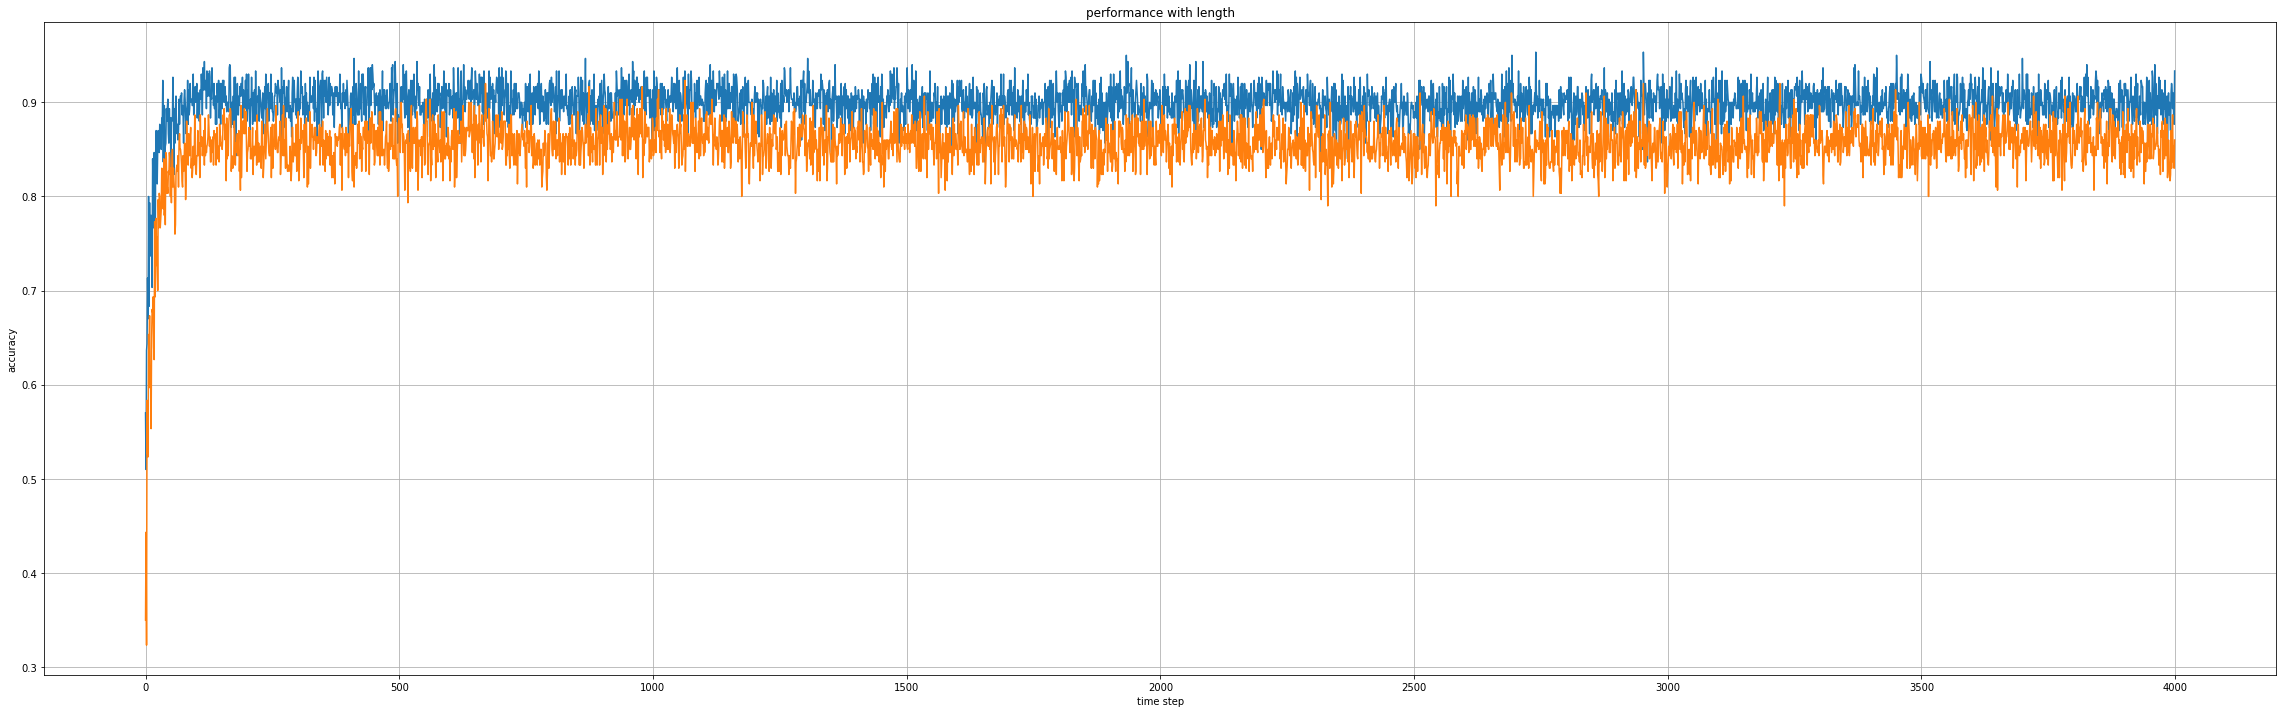

In [3]:
plt.figure(figsize=(40, 12))
plt.plot(nt_accuracy, label='non-terminal')
plt.plot(tt_accuracy, label='terminal')
plt.xlabel('time step')
plt.ylabel('accuracy')
plt.title('performance with length')
plt.grid()

In [4]:
for i in range(50):
    print(i, '  ', tt_accuracy[i])

0    0.35
1    0.44333333
2    0.32333332
3    0.5833333
4    0.52666664
5    0.5233333
6    0.6533333
7    0.63666666
8    0.67333335
9    0.5966667
10    0.62
11    0.55333334
12    0.65
13    0.68
14    0.6766667
15    0.6933333
16    0.64
17    0.62666667
18    0.7733333
19    0.6933333
20    0.72
21    0.77666664
22    0.7266667
23    0.75666666
24    0.7
25    0.7966667
26    0.76666665
27    0.80333334
28    0.8
29    0.76666665
30    0.77666664
31    0.7866667
32    0.83
33    0.82
34    0.8066667
35    0.7866667
36    0.84
37    0.78
38    0.7966667
39    0.77
40    0.8466667
41    0.8433333
42    0.80333334
43    0.81
44    0.80333334
45    0.82666665
46    0.8233333
47    0.8466667
48    0.84
49    0.8


In [ ]:
for i in range(50):
    print(i , '  ' , nt_accuracy[i])

In [ ]:
x = np.arange(5000)
xnew = np.linspace(x.min(), x.max(), 500)
spl = make_interp_spline(x, nt_accuracy, k=3)
smooth = spl(xnew)
plt.plot(xnew, smooth)
spl = make_interp_spline(x, tt_accuracy, k=3)
smooth = spl(xnew)
plt.plot(xnew, smooth)
plt.xlabel('time step')
plt.ylabel('accuracy')
plt.title('performance with length')
plt.grid()

In [ ]:
plt.plot(nt_accuracy, label='non-terminal')
plt.plot(tt_accuracy, label='terminal')

In [ ]:
import pickle
count = pickle.load(open('longth_count_info.p', 'rb'))


In [ ]:
sort_count = sorted(count.items(), key=lambda x: x[0],reverse=True)

In [ ]:
ccc = 0
for long, cou in sort_count:
    if long >= 5000:
        ccc += cou
print(ccc)

In [ ]:
import utils
tt_token_to_int, tt_int_to_token, nt_token_to_int, nt_int_to_token = utils.load_dict_parameter()

In [ ]:
print(len(nt_token_to_int))

In [ ]:
print(nt_token_to_int['WhileStatement=$$=False=$$=False'])

In [ ]:
print(len(tt_int_to_token))

In [ ]:
import json 
path = 'js_dataset/js_programs_training.json'
file = open(path)

In [ ]:
a = file.readline()
a = json.loads(a)

In [ ]:
from collections import Counter
import pickle
count = Counter()
path = 'split_js_data/train_data/int_format/'
for i in range(1, 21):
    a_path = path + 'int_part{}.json'.format(i)
    data = pickle.load(open(a_path, 'rb'))
    for n, t in data:
        count[n] += 1

In [ ]:
print(len(count))

In [ ]:
a = []
for i in range(126):
    if i not in count.keys():
        print(i)

In [ ]:
print(nt_int_to_token[49])
print(nt_int_to_token[59])
print(nt_int_to_token[123])
# print(nt_int_to_token[99])
'''
BlockStatement=$$=True=$$=False
LabeledStatement=$$=False=$$=False
LabeledStatement=$$=True=$$=False
IfStatement=$$=False=$$=False
'''

In [ ]:
print(nt_token_to_int['LabeledStatement=$$=False=$$=False'])
count[124]

In [ ]:
print(nt_token_to_int['BlockStatement=$$=True=$$=False'])

In [ ]:
print(count[2])

In [ ]:
print(nt_int_to_token)







In [ ]:
from gensim.models import word2vec


sentences = word2vec.Text8Corpus('text8')
model = word2vec.Word2Vec(sentences)

In [ ]:
ast_example = [{'id': 0, 'type': 'Program', 'children': [1]},
                   {'id': 1, 'type': 'ExpressionStatement', 'children': [2]},
                   {'id': 2, 'type': 'CallExpression', 'children': [3, 8, 9, 10]},
                   {'id': 3, 'type': 'MemberExpression', 'children': [4, 7]},
                   {'id': 4, 'type': 'MemberExpression', 'children': [5, 6]},
                   {'id': 5, 'type': 'Identifier', 'value': 'CKEDITOR'},
                   {'id': 6, 'type': 'Property', 'value': 'plugins'},
                   {'id': 7, 'type': 'Property', 'value': 'setLang'},
                   {'id': 8, 'type': 'LiteralString', 'value': 'iframe'},
                   {'id': 9, 'type': 'LiteralString', 'value': 'ka'},
                   {'id': 10, 'type': 'ObjectExpression', 'children': [11, 13, 15, 17, 19]},
                   {'id': 11, 'type': 'Property', 'value': 'border', 'children': [12]},
                   {'id': 12, 'type': 'LiteralString', 'value': 'ჩარჩოს გამოჩენა'},
                   {'id': 13, 'type': 'Property', 'value': 'noUrl', 'children': [14]},
                   {'id': 14, 'type': 'LiteralString', 'value': 'აკრიფეთ iframe-ის URL'},
                   {'id': 15, 'type': 'Property', 'value': 'scrolling', 'children': [16]},
                   {'id': 16, 'type': 'LiteralString', 'value': 'გადახვევის ზოლების დაშვება'},
                   {'id': 17, 'type': 'Property', 'value': 'title', 'children': [18]},
                   {'id': 18, 'type': 'LiteralString', 'value': 'IFrame-ის პარამეტრები'},
                   {'id': 19, 'type': 'Property', 'value': 'toolbar', 'children': [20]},
                   {'id': 20, 'type': 'LiteralString', 'value': 'IFrame'}, 0]


def bulid_binary_tree(ast):
    """transform the AST(one node may have several childNodes) to
    Left-Child-Right-Sibling(LCRS) binary tree."""
    brother_map = {0: -1}
    for index, node in enumerate(ast):  # 顺序遍历每个AST中的node

        if not isinstance(node, dict) and node == 0:  # AST中最后添加一个'EOF’标识
            ast[index] = 'EOF'
            break  # return data

        node['right'] = brother_map.get(node['id'], -1)

        if 'children' in node.keys():  # 表示该node为non-terminal
            node['isTerminal'] = False
            add_two_bits_info(ast, node, brother_map)  # 向每个节点添加两bit的额外信息
            child_list = node['children']
            node['left'] = child_list[0]  # 构建该node的left node
            for i, bro in enumerate(child_list):  # 为该node的所有children构建right sibling
                if i == len(child_list) - 1:
                    break
                brother_map[bro] = child_list[i + 1]
        else:
            node['isTerminal'] = True
    return ast


def add_two_bits_info(ast, node, brother_map):
    # 向每个节点添加两bit的额外信息：hasNonTerminalChild和hasSibling
    node['hasNonTerminalChild'] = False
    for child_index in node['children']:
        if 'children' in ast[child_index]:
            node['hasNonTerminalChild'] = True
            break
    if brother_map.get(node['id'], -1) == -1:
        node['hasSibling'] = False
    else:
        node['hasSibling'] = True

In [ ]:
import utils
tt_token_to_int, tt_int_to_token, nt_token_to_int, nt_int_to_token = utils.load_dict_parameter()
print(len(tt_token_to_int))
print(len(nt_token_to_int))

In [ ]:
bin_tree = bulid_binary_tree(ast_example)
bin_tree

In [ ]:
print(bin_tree)

In [ ]:
def ast_to_seq(binary_tree):
    # 将一个ast首先转换成二叉树，然后对该二叉树进行中序遍历，得到nt_sequence
    def node_to_string(node):
        # 将一个node转换为string
        if node == 'EMPTY':
            string_node = 'EMPTY'
        elif node['isTerminal']:  # 如果node为terminal
            string_node = str(node['type']) + '=$$=' + \
                str(node['value'])   + '==' + str(node['id'])
            terminal_count[string_node] += 1
        else:  # 如果是non-terminal
            string_node = str(node['type']) + '=$$=' + \
                str(node['hasSibling']) + '=$$=' + \
                str(node['hasNonTerminalChild'])  + str(node['id'])
                # 有些non-terminal包含value，探索该value的意义？（value种类非常多）
            non_termial_set.add(string_node)
        return string_node

    def in_order_traversal(bin_tree, index):
        # 对给定的二叉树进行中序遍历，并在中序遍历的时候，生成nt_pair
        node = bin_tree[index]
        if 'left' in node.keys():
            in_order_traversal(bin_tree, node['left'])

        if 'isTerminal' in node.keys() and node['isTerminal'] is False:
            # 如果该node是non-terminal，并且包含一个terminal 子节点，则和该子节点组成nt_pair保存在output中
            # 否则将nt_pair的T设为字符串EMPTY
            n_pair = node_to_string(node)
            for child_index in node['children']:  # 遍历该Nterminal的所有child，分别用所有child构建NT-pair
                if bin_tree[child_index]['isTerminal']:
                    t_pair = node_to_string(bin_tree[child_index])
                else:
                    t_pair = node_to_string('EMPTY')
                nt_pair = (n_pair, t_pair)
                output.append(nt_pair)

            # if bin_tree[node['left']]['isTerminal']:
            #     assert bin_tree[node['left']]['id'] == node['left']
            #     t_pair = node_to_string(bin_tree[node['left']])
            # else:
            #     t_pair = node_to_string('EMPTY')
            # nt_pair = (n_pair, t_pair)
            # output.append(nt_pair)
        else:  # 该token是terminal，只将其记录到counter中
            node_to_string(node)

        if node['right'] != -1:  # 遍历right side
            in_order_traversal(bin_tree, node['right'])

    output = []
    in_order_traversal(binary_tree, 0)
    return output

In [ ]:
from collections import Counter
terminal_count = Counter()  # 统计每个terminal token的出现次数
non_termial_set = set()  # 统计non_termial token 种类

In [ ]:
seq = ast_to_seq(bin_tree)
seq

In [ ]:
import numpy as np
import pandas as pd
import pickle
import json

js_test_data_dir = 'js_dataset/js_programs_eval.json'
js_train_data_dir = 'js_dataset/js_programs_training.json'

def dataset_split(is_training=True, subset_size=5000):
    if is_training:
        data_path = js_train_data_dir
        total_size = 100000
        saved_to_path = 'split_js_data/train_data/'
    else:
        data_path = js_test_data_dir
        total_size = 50000
        saved_to_path = 'split_js_data/eval_data/'

    file = open(data_path, 'r')
    subset_list = []
    error_count = 0
    for i in range(1, total_size + 1):
        try:
            line = file.readline()
            line = json.loads(line)
            nt_seq = ast_to_seq(line)
        except:
            error_count += 1
           # print('UTF-8 error: {}/{}'.format(error_count, i))
        subset_list.append(nt_seq)
        if i % subset_size == 0:
#             sub_path = saved_to_path + 'part{}'.format(i // subset_size) + '.json'
#             save_file = open(sub_path, 'wb')
#             pickle.dump(subset_list, save_file)
            subset_list = []
    print('data seperating finished..., utf-8 error:{}'.format(error_count))

In [ ]:
def add_two_bits_info(node, brother_map):
    # 向每个节点添加两bit的额外信息：isTerminal和hasSibling
    if 'children' in node.keys():
        node['isTerminal'] = False
    else:
        node['isTerminal'] = True
    if brother_map.get(node['id'], -1) == -1:
        node['hasSibling'] = False
    else:
        node['hasSibling'] = True


def bulid_binary_tree(data):
    '''
    transform the AST(one node may have several childNodes) to 
    Left-Child-Right-Sibling(LCRS) binary tree.
    '''
    brother_map = {0: -1}
    for index, node in enumerate(data): # 顺序遍历每个AST中的node
        if type(node) != dict and node == 0: # AST中最后添加一个'EOF’标识
            data[index] = 'EOF'
            return data
        # 向每个节点添加两bit的额外信息
        add_two_bits_info(node, brother_map)
        node['right'] = brother_map.get(node['id'], -1)
        # 表示该node为non-terminal
        if 'children' in node.keys():
            child_list = node['children']
            node['left'] = child_list[0] # 构建该node的left node
            for i, bro in enumerate(child_list): # 为该node的所有children构建right sibling
                if i == len(child_list)-1:
                    break
                brother_map[bro] = child_list[i+1]
            node.pop('children')
    return data

In [ ]:
from collections import Counter

token2int = {}
int2token = {}
terminalCountMap = Counter()
nonTerminalSet =  set()


        
        
def ast_to_seq(data):
    bi_tree = bulid_binary_tree(data)
 #   print(bi_tree)
    
    def node_to_string(node):
        if node == 'EMPTY':
            string_node = 'EMPTY'
        elif node['isTerminal']:  # 如果node为terminal
            string_node = str(node['type'])+'=$$='+str(node['value']) ## + '==' + str(node['id'])
            terminalCountMap[string_node] += 1
        else:  # if it is a non-terminal
            string_node = str(node['type']) + '=$$=' + \
                          str(node['hasSibling']) + '=$$=' + \
                          str(node['isTerminal']) # + '==' +str(node['id'])
            if 'value' in node.keys(): # Note:There are some non-terminal contains 'value', use it?
                string_node += '=$$=' + str(node['value'])
            nonTerminalSet.add(string_node)
            # todo: display the set of nonTerSet
        return string_node

    def in_order_traversal(data, index):
        node = data[index]
        if 'left' in node.keys():
            in_order_traversal(data, node['left'])
        # 如果该节点为non-terminal，则构建NT-pair并加入到sequence中。
        if 'isTerminal' in node.keys() and node['isTerminal'] == False:
            '''如果该node是non-terminal
            如果该non-terminal包含一个terminal 子节点，则和该子节点组成NT_pair保存在output中
            否则将NT_pair的T设为字符串EMPTY'''
            N_pair = node_to_string(node)
            T_pair = None
            if data[node['left']]['isTerminal']==True:
                assert data[node['left']]['id'] == node['left']
                T_pair = node_to_string(data[node['left']])
            else:
                T_pair = node_to_string('EMPTY')
            NT_pair = (N_pair, T_pair)
            output.append(NT_pair)
        else:
            node_to_string(node)
        # 遍历right side
        if node['right'] != -1:
            in_order_traversal(data, node['right'])
    output = []
    in_order_traversal(bi_tree, 0)
    return output

output = ast_to_seq(ast_example)
print(output)

In [ ]:
data_parameter_dir = 'split_js_data/parameter.p'
def load_dict_parameter():
    file = open(data_parameter_dir, 'rb')
    terminalToken2int, terminalInt2token, nonTerminalToken2int, nonTerminalInt2token = pickle.load(file)
    return terminalToken2int, terminalInt2token, nonTerminalToken2int, nonTerminalInt2token

In [ ]:
terminalToken2int, terminalInt2token, nonTerminalToken2int, nonTerminalInt2token = load_dict_parameter()

In [ ]:
terminalToken2int, terminalInt2token, nonTerminalToken2int, nonTerminalInt2token = load_dict_parameter()
print(len(nonTerminalInt2token))
print(len(terminalInt2token))


In [ ]:
def process_nt_seq(time_steps=50):
    '''
    对已经处理好的NT seq进行进一步的处理，
    首先将每个token转换为number，然后截取各个seq成50的倍数，（50为time-steps大小）
    然后将每个AST都拼接到一起，
    '''
    terminalToken2int, terminalInt2token, nonTerminalToken2int, nonTerminalInt2token = load_dict_parameter()
    num_subset_train_data = 20
    subset_data_dir = 'split_js_data/train_data/'
    total_num_nt_pair = 0
    
    def get_subset_data(): #对每个part的nt_sequence读取并返回，等待进行处理
        for i in range(1, num_subset_train_data + 1):
            data_path = subset_data_dir + f'part{i}.json'
            file = open(data_path, 'rb')
            data = pickle.load(file)
            yield (i, data)

    subset_generator = get_subset_data()
    for index, data in subset_generator:
#        data = pickle.load(open(subset_data_dir+'part1.json', 'rb'))
        data_seq = []
        for one_ast in data: # 将每个nt_seq进行截取，并encode成integer，然后保存
            num_steps = len(one_ast) // time_steps # 将每个nt seq都切割成time steps的整数倍
            if num_steps == 0: # 该ast大小不足time step 舍去
                continue
            one_ast = one_ast[:num_steps * time_steps]
            nt_int_seq = [(nonTerminalToken2int[n], terminalToken2int.get(t, terminalToken2int['UNK'])) 
                          for n, t in one_ast]
            data_seq.extend(nt_int_seq)
        print(len(data_seq))
        total_num_nt_pair += len(data_seq)
        with open(subset_data_dir+f'int_format/part{index}.json', 'wb') as file:
            pickle.dump(data_seq, file)
            print(f'part{index} of nt_seq data has been encoded into integer and saved...')
    print(f'There are {total_num_nt_pair} of nt_pair in train data set...') # total == 6970900
process_nt_seq()

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import data_utils
import time


In [ ]:
processed_data_path = 'processed_data/rnn_train_data.p'
data_parameter_path = 'processed_data/rnn_train_parameter.p'
tensorboard_log_path = 'logs/MultiRNN'

train_dir = 'dataset/programs_800'
test_dir = 'dataset/programs_200'
checkpoint_dir = 'checkpoints/'

num_epoches = 1
show_every_n = 50
save_every_n = 200

In [ ]:
import json
import os

def load_tokens(train_flag=True, is_simplify=True):
    if train_flag:
        token_dir = train_dir
    else:
        token_dir = test_dir
    token_list = []
    for f in os.listdir(token_dir):
        file_path = os.path.join(token_dir, f)
        if os.path.isfile(file_path) and f.endswith('_tokens.json'):
            #print(file_path)
            token_seq = json.load(open(file_path, encoding='utf-8'))
            token_list.extend(token_seq)
    string_token_list = []
    for token in token_list:
        if is_simplify:
            data_utils.simplify_token(token)
        string_token = data_utils.token_to_string(token)
        string_token_list.append(string_token)
    token_set = list(set(string_token_list))
    #print(string_token_list[:10])
    string2int = {c:i for i,c in enumerate(token_set)}
    int2string = {i:c for i,c in enumerate(token_set)}
    int_token_list = [string2int[c] for c in string_token_list]
    #print(int_token_list[:10])
    pickle.dump((int_token_list), open(processed_data_path, 'wb'))
    pickle.dump((string2int, int2string, token_set), open(data_parameter_path, 'wb'))

In [ ]:
'''
Using MultiRNN to pridect token. with LSTM cell
'''
class LSTM_Model(object):
    def __init__(self,
                 token_set, time_steps=100,
                 batch_size=64,
                 num_layers=2,
                 n_units=128,
                 learning_rate=0.003,
                 grad_clip=5,
                 keep_prob=0.5,
                 num_epoches = 5,
                 is_training=True):
        
        if is_training:
            self.time_steps = time_steps
            self.batch_size = batch_size
        else:
            self.time_steps = 1
            self.batch_size = 1
        
        self.token_set =  token_set
        self.num_classes = len(self.token_set)
        self.num_layers = num_layers
        self.n_units = n_units
        self.learning_rate = learning_rate
        self.grad_clip = grad_clip
        self.keep_prob = keep_prob
        self.num_epoches = num_epoches

        self.bulid_model()


    def get_batch(self, data_seq, n_seq, n_steps):
        '''
        :param n_seq: 一个batch中序列的个数
        :param n_steps: 单个序列中包含字符的个数
        '''
        data_seq = np.array(data_seq)
        batch_size = n_steps * n_seq
        n_batches = len(data_seq) // batch_size
        data_seq = data_seq[:batch_size * n_batches] #仅保留完整的batch，舍去末尾
        data_seq = data_seq.reshape((n_seq, -1))
        for n in range(0, data_seq.shape[1], n_steps):
            x = data_seq[:, n:n+n_steps]
            y = np.zeros_like(x)
            y[:, :-1], y[:, -1] = x[:, 1:], x[:,0]
            yield x, y

    def build_input(self):
        input_x = tf.placeholder(tf.int32, [self.batch_size, self.time_steps], name='input_x')
        target_y = tf.placeholder(tf.int32, [self.batch_size, self.time_steps], name='target_y')
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        return input_x, target_y, keep_prob

    def bulid_lstm(self, keep_prob):
        cell_list = []
        for i in range(self.num_layers):
            cell = tf.contrib.rnn.BasicLSTMCell(self.n_units, state_is_tuple=True)
            cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
            cell_list.append(cell)
        cells = tf.contrib.rnn.MultiRNNCell(cell_list, state_is_tuple=True)
        init_state = cells.zero_state(self.batch_size, dtype=tf.float32)

        return cells, init_state

    def bulid_output(self, lstm_output):
        # 将lstm_output的形状由[batch_size, time_steps, n_units] 转换为 [batch_size*time_steps, n_units]
        seq_output = tf.concat(lstm_output, axis=1)
        seq_output = tf.reshape(seq_output, [-1, self.n_units])

        with tf.variable_scope('softmax'):
            softmax_w = tf.Variable(tf.truncated_normal([self.n_units, self.num_classes], stddev=0.1))
            softmax_b = tf.Variable(tf.zeros(self.num_classes))

        logits = tf.matmul(seq_output, softmax_w) + softmax_b
        softmax_output = tf.nn.softmax(logits=logits, name='softmax_output')
        return softmax_output, logits

    def bulid_loss(self, logits, targets):
        one_hot_y = tf.one_hot(targets, self.num_classes)
        one_hot_y = tf.reshape(one_hot_y, logits.get_shape())
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_y)
        loss = tf.reduce_mean(loss)
        return loss

    def bulid_optimizer(self,loss):
        # tvars = tf.trainable_variables()
        # grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), self.grad_clip)
        # optimizer = tf.train.AdamOptimizer(self.learning_rate)
        # optimizer = optimizer.apply_gradients(zip(grads, tvars))
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        gradient_pairs = optimizer.compute_gradients(loss)
        clip_gradient_pairs = []
        for grad, var in gradient_pairs:
            grad = tf.clip_by_value(grad, -2, 2)
            clip_gradient_pairs.append((grad, var))
        optimizer = optimizer.apply_gradients(clip_gradient_pairs)
        return optimizer
    
    def build_accuracy(self, logits, targets):
#         print(logits.get_shape())
#         print(targets.get_shape())
        sess = tf.Session()
        self.show_logits = tf.argmax(logits, axis=1)
        show_targets = tf.one_hot(targets, self.num_classes)
        show_targets = tf.reshape(show_targets, logits.get_shape())
        self.show_targets = tf.argmax(show_targets, axis=1)
        self.aaa = tf.equal(self.show_logits, self.show_targets)
        accu = tf.cast(self.aaa, tf.float32)
        accu = tf.reduce_mean(accu)
        return accu
        

    def bulid_model(self):
        tf.reset_default_graph()
        self.input_x, self.target_y, self.keep_prob = self.build_input()
        self.cell, self.init_state = self.bulid_lstm(self.keep_prob)
        one_hot_x = tf.one_hot(self.input_x, self.num_classes)
        #print(one_hot_x.get_shape()) # (64, 100, 86)
        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
            self.cell, one_hot_x, initial_state=self.init_state)
        #print(1, lstm_outputs.get_shape()) # (64, 100, 128)
        self.softmax_output, logits = self.bulid_output(lstm_outputs)
        #print(self.softmax_output.get_shape()) # (6400, 86)
        #print(logits.get_shape()) #(6400, 86)
        self.loss = self.bulid_loss(logits,self.target_y)
        self.accuracy = self.build_accuracy(self.softmax_output, self.target_y)
        self.optimizer = self.bulid_optimizer(self.loss)


    def train(self, data, string2int, int2string):
        print('training begin...')
        self.string2int = string2int
        self.int2string = int2string
        saver = tf.train.Saver(max_to_keep=100)
        keep_prob = 0.5
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            global_step = 0
            for epoch in range(self.num_epoches):
                new_state = sess.run(self.init_state)
                batch_generator = self.get_batch(data, self.batch_size, self.time_steps)
                batch_step = 0
                start_time = time.time()
                for x, y in batch_generator:
                    global_step += 1
                    batch_step += 1
                    feed = {self.input_x:x,
                            self.target_y:y,
                            self.keep_prob:keep_prob,
                            self.init_state:new_state}
                    show_accu, show_loss, new_state, _ = sess.run(
                        [self.accuracy, self.loss, self.final_state, self.optimizer], feed_dict=feed)
                    end_time = time.time()
                    if global_step%show_every_n == 0:
                        a, b,c = sess.run([self.show_logits, self.show_targets,self.aaa], feed)
                        print(a[:10])
                        print(b[:10])
                    if global_step % show_every_n == 0:
                        print('epoch: {}/{}..'.format(epoch+1, self.num_epoches),
                              'global_step: {}..'.format(global_step),
                              'train_loss: {:.2f}..'.format(show_loss),
                              'train_accuracy: {:.2f}..'.format(show_accu),
                              'time cost in per_batch: {:.2f}..'.format(end_time-start_time))

                    if global_step % save_every_n == 0:
                        saver.save(sess, 'checkpoints/epoch{}_batch_step{}'.format(epoch, batch_step))
            saver.save(sess, 'checkpoints/last_check')

In [ ]:
train_data = data_utils.load_data_with_pickle(processed_data_path)
string2int, int2string, token_set = data_utils.load_data_with_pickle(data_parameter_path)

In [ ]:
print(int2string[22])

In [ ]:
model = LSTM_Model(token_set)
model.train(train_data, string2int, int2string)

In [ ]:
class TestModel(object):
    def __init__(self, token_set,string2int, int2string):
        self.model = LSTM_Model(token_set, is_training=False)
        self.string2int = string2int
        self.int2string = int2string
        self.last_chackpoints = tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir)

    # query test
    def query_test(self, prefix, suffix):
        '''
        Input: all tokens before the hole token(prefix) and all tokens after the hole token,
        ML model will predict the most probable token in the hole
        '''
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, self.last_chackpoints)
            new_state = sess.run(self.model.init_state)
            prediction = None
            for i,token in enumerate(prefix):
                x = np.zeros((1, 1), dtype=np.int32)
                x[0,0] = token
                feed = {self.model.input_x:x,
                        self.model.keep_prob:1.,
                        self.model.init_state:new_state}
                prediction, new_state = sess.run(
                    [self.model.softmax_output, self.model.final_state], feed_dict=feed)
        prediction = self.int2string[np.argmax(prediction)]
        return prediction

    def test(self, query_test_data):
        correct = 0.0
        correct_token_list = []
        incorrect_token_list = []
        for token_sequence in query_test_data:
            prefix, expection, suffix = data_utils.create_hole(token_sequence)
            prefix = self.token_to_int(prefix)
            prediction = self.query_test(prefix, suffix)
            prediction = data_utils.string_to_token(prediction)
            if data_utils.token_equals([prediction], expection):
                correct += 1
                correct_token_list.append({'expection': expection, 'prediction': prediction})
            else:
                incorrect_token_list.append({'expection': expection, 'prediction': prediction})
        accuracy = correct / len(query_test_data)
        return accuracy
    
    def token_to_int(self, token_seq):
        int_token_seq = []
        for token in token_seq:
            int_token = self.string2int[data_utils.token_to_string(token)]
            int_token_seq.append(int_token)
        return int_token_seq

In [ ]:
test_data = data_utils.load_data_with_file(test_dir)

In [ ]:
test_model = TestModel(token_set, string2int, int2string)
accuracy = test_model.test(test_data)
print(accuracy)

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import time
import data_utils

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



'''
使用TensorFlow自带的layers构建基本的神经网络对token进行预测，
可以声明使用多少个context tokens 进行预测

多个previous token输入神经网络的方法有两种想法：
1. 将每个token的representation vector相连，合成一个大的vector输入到神经网络，
    所以说神经网络的输入层大小应为：每个token vector length * number of previous token
2. 应为目前表示每个token 使用的方法为one hot encoding，也就是说对每个token都是有且仅有一位为1，其余位为0，
    所以可以考虑直接将所有的previous token相加，这样做的好处是NN输入层大小永远等于vector length。缺点是没有理论依据，不知道效果是否会更好


1. concatenate the representations of previous tokens to a huge vector representation
2. add the representations of previous tokens together


'''

x_train_data_path = 'processed_data/x_train_data.p'
y_train_data_path = 'processed_data/y_train_data.p'
train_data_parameter = 'processed_data/x_y_parameter.p'
query_dir = 'dataset/programs_200/'

tensorboard_data_path = './logs/MultiContext/5_previous'

epoch_num = 2
batch_size = 64
learning_rate = 0.002
context_size = 5
hidden_size = 64

In [ ]:
class Code_Completion_Model:

    def __init__(self, x_data, y_data, token_set, string2int, int2string, add_or_concat='add'):
        batch_num = len(x_data) // batch_size
        x_data, y_data = np.array(x_data[:batch_num * batch_size]), np.array(y_data[:batch_num * batch_size])
        if add_or_concat == 'add':
            temp_x, temp_y = self.reshape_with_add(x_data, y_data)
        if add_or_concat == 'concat':
            temp_x, temp_y = self.reshape_with_concat(x_data, y_data)
        self.x_data, self.valid_x, self.y_data, self.valid_y = \
            train_test_split(temp_x, temp_y, train_size=0.9)
        self.data_size = len(self.x_data)
        self.index_to_string = int2string
        self.string_to_index = string2int
        self.tokens_set = token_set
        self.tokens_size = len(token_set)

    def reshape_with_concat(self, x_data, y_data):
        reshape_data = []
        reshape_label = []
        for i in range(len(x_data)):
            if i >= context_size-1:
                temp_list = []
                for x in range(context_size):
                    temp_list.extend(x_data[i-x])
                reshape_data.append(temp_list)
                reshape_label.append(y_data[i])
        return reshape_data, reshape_label
        
    def reshape_with_add(self, x_data, y_data):
        x = []
        y = []
        for index, token in enumerate(x_data):
            if index >= context_size - 1:
                tempTokens = np.sum(x_data[index - context_size + 1:index + 1, :], axis=0)
                x.append(tempTokens)
                y.append(y_data[index])
        return x, y;

    # neural network functions
    def create_NN(self):
        tf.reset_default_graph()
        self.input_x = tf.placeholder(dtype=tf.float32, shape=[None, self.tokens_size], name='input_x')
        self.output_y = tf.placeholder(dtype=tf.float32, shape=[None, self.tokens_size], name='output_y')
        weights = {'h1': tf.Variable(tf.truncated_normal(shape=[self.tokens_size, hidden_size])),
                   'h2': tf.Variable(tf.truncated_normal(shape=[hidden_size, hidden_size])),
                   'h3': tf.Variable(tf.truncated_normal(shape=[hidden_size, hidden_size])),
                   'output': tf.Variable(tf.truncated_normal(shape=[hidden_size, self.tokens_size]))}
        biases = {'h1': tf.Variable(tf.constant(0.1, shape=[hidden_size], dtype=tf.float32)),
                  'h2': tf.Variable(tf.constant(0.1, shape=[hidden_size], dtype=tf.float32)),
                  'h3': tf.Variable(tf.constant(0.1, shape=[hidden_size], dtype=tf.float32)),
                  'output': tf.Variable(tf.constant(0.1, shape=[self.tokens_size], dtype=tf.float32))}

        h1_layer = tf.matmul(self.input_x, weights['h1']) + biases['h1']
        h1_layer = tf.nn.relu(h1_layer)
        h2_layer = tf.matmul(h1_layer, weights['h2']) + biases['h2']
        h2_layer = tf.nn.relu(h2_layer)
        h3_layer = tf.matmul(h2_layer, weights['h3']) + biases['h3']
        h3_layer = tf.nn.relu(h3_layer)
        output_layer = tf.matmul(h3_layer, weights['output']) + biases['output']
        self.prediction = tf.argmax(output_layer, 1)
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=self.output_y)
        self.loss = tf.reduce_mean(loss)
        self.optimizer_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        equal = tf.equal(tf.argmax(output_layer, 1), tf.argmax(self.output_y, 1))
        accuracy = tf.cast(equal, tf.float32)
        self.accuracy = tf.reduce_mean(accuracy)
        
#         self.valid_loss = tf.reduce_mean(loss)
#         self.valid_accuracy = tf.reduce_mean(accuracy)

        tf.summary.histogram('weight1', weights['h1'])
        tf.summary.histogram('weight2', weights['h2'])
        tf.summary.histogram('output_weight', weights['output'])
        tf.summary.histogram('bias1', biases['h1'])
        tf.summary.histogram('bias2', biases['h2'])
        tf.summary.histogram('output_bias', biases['output'])
        tf.summary.scalar('train_loss', self.loss)
        tf.summary.scalar('train_accuracy', self.accuracy)
         
        self.merged = tf.summary.merge_all()

    def get_batch(self):
        for i in range(0, len(self.x_data), batch_size):
            batch_x = self.x_data[i:i + batch_size];
            batch_y = self.y_data[i:i + batch_size];
            yield batch_x, batch_y

    def train(self):
        self.create_NN()
        self.sess = tf.Session()
        valid_accu_list = np.zeros(10, dtype=np.float32)
        train_accu_list = np.zeros(10, dtype=np.float32)
        valid_list_index = 0
        train_list_index = 0
        writer = tf.summary.FileWriter(tensorboard_data_path, self.sess.graph)
        time_begin = time.time()
        self.sess.run(tf.global_variables_initializer())
        for epoch in range(epoch_num):
          #  self.x_data, self.y_data = shuffle(self.x_data, self.y_data)
            batch_generator = self.get_batch()
            for i in range(0, len(self.x_data), batch_size):
                batch_x, batch_y = next(batch_generator)
                feed = {self.input_x: batch_x, self.output_y: batch_y}
                _, summary_str = self.sess.run([self.optimizer_op, self.merged], feed_dict=feed)
                writer.add_summary(summary_str, epoch*self.data_size + i)
                writer.flush()
                if (i // batch_size) % 2000 == 0:
                    print('epoch: %d, step: %d'%(epoch, i))
                    train_loss, train_accu = self.sess.run([self.loss, self.accuracy], feed_dict=feed)
                    train_accu_list[train_list_index % 10] = train_accu
                    print('train loss: %.2f, train accuracy:%.3f' % (train_loss, train_accu))
                    print('average train accuracy: %.4f'%(np.mean(train_accu_list)))
                    valid_feed = {self.input_x:self.valid_x, self.output_y:self.valid_y}
                    valid_loss, valid_acc = self.sess.run([self.loss, self.accuracy], feed_dict=valid_feed)
                    valid_accu_list[valid_list_index % 10] = valid_acc
                    print('valid loss: %.2f, valid accuracy:%.3f' % (valid_loss, valid_acc))
                    print('average valid accuracy: %.4f'%(np.mean(valid_accu_list)))
        time_end = time.time()
        print('training time cost: %.3f s' % (time_end - time_begin))

    # query test
    def query_test(self, prefix, suffix):
        '''
        Input: all tokens before the hole token(prefix) and all tokens after the hole token,
        ML model will predict the most probable token in the hole. In this function, use only one token before hole token to predict
        '''
        previous_token_list = prefix[-context_size:]
        context_representation = np.zeros(self.tokens_size)

        for token in previous_token_list:
            prev_token_string = data_utils.token_to_string(token)
            pre_token_x = data_utils.one_hot_encoding(prev_token_string, self.string_to_index)
            context_representation += np.array(pre_token_x)

        feed = {self.input_x: [context_representation]}
        prediction = self.sess.run(self.prediction, feed)[0]
        best_string = self.index_to_string[prediction]
        best_token = data_utils.string_to_token(best_string)
        return [best_token]

    # test model
    def test_model(self, query_test_data):
        correct = 0.0
        correct_token_list = []
        incorrect_token_list = []
        for token_sequence in query_test_data:
            prefix, expection, suffix = data_utils.create_hole(token_sequence)
            prediction = self.query_test(prefix, suffix)[0]
            if data_utils.token_equals([prediction], expection):
                correct += 1
                correct_token_list.append({'expection': expection, 'prediction': prediction})
            else:
                incorrect_token_list.append({'expection': expection, 'prediction': prediction})
        accuracy = correct / len(query_test_data)
        return accuracy

In [ ]:
x_train_data_path = 'processed_data/x_train_data.p'
y_train_data_path = 'processed_data/y_train_data.p'
train_data_parameter = 'processed_data/x_y_parameter.p'
x_data = data_utils.load_data_with_pickle(x_train_data_path)
y_data = data_utils.load_data_with_pickle(y_train_data_path)
token_set, string2int, int2string = data_utils.load_data_with_pickle(train_data_parameter)

In [ ]:
#model train
model = Code_Completion_Model(x_data, y_data, token_set, string2int, int2string)
model.train()

In [ ]:
# test model
query_test_data = data_utils.load_data_with_file(query_dir)
accuracy = model.test_model(query_test_data)
print('query test accuracy: ', accuracy)

In [ ]:
import random
from collections import Counter
import data_utils
string_processed_data_path = 'processed_data/str_train_data.p'

class Markov_Model(object):

    def __init__(self, max_length=1, is_most=False):
        self.markov_table = {}
        self.max_length = 1
        self.is_most = False

    def create_model(self, token_list, max_depth=1, is_most=False):
        '''
        create a markov model with the depth from 1 to max_depth
        {
            depth1:{
                key1:[value1, value2 ..]
            }
        }
        '''
        self.is_most = is_most
        self.max_length = max_depth
        for depth in range(1, max_depth+1):
            temp_table = {}
            for index in range(depth, len(token_list)):
                words = tuple(token_list[index-depth:index])
                if words in temp_table.keys():
                    temp_table[words].append(token_list[index])
                else:
                    temp_table.setdefault(words, []).append(token_list[index])
            if is_most:
                for key,value in temp_table.items():
                    temp = Counter(value).most_common(1)[0][0]
                    temp_table[key] = temp
                self.markov_table[depth] = temp_table
            else:
                self.markov_table[depth] = temp_table
        return self.markov_table

    def test_model(self, test_token_lists, depth=1):
        correct = 0
        correct_token_list = []
        incorrect_token_list = []

        for tokens in test_token_lists:
            prefix, expection, suffix = data_utils.create_hole(tokens)
            prediction = self.query_test(prefix, depth=depth)
            if prediction['type']==expection[0]['type'] and prediction['value'] == expection[0]['value']:
                correct += 1
                correct_token_list.append({'expection': expection, 'prediction': prediction})
            else:
                incorrect_token_list.append({'expection': expection, 'prediction': prediction})
        accuracy = correct / len(test_token_lists)
        return accuracy


    def query_test(self, pre_tokens, depth=1):
        while(depth>self.max_length):
            depth -= 1
        used_tokens = pre_tokens[-depth:]
        proceed_tokens = []
        for token in used_tokens:
            proceed_tokens.append(data_utils.token_to_string(token))
        proceed_tokens = tuple(proceed_tokens)
        while proceed_tokens not in self.markov_table[depth].keys() and depth > 1:
            depth -= 1
            proceed_tokens = tuple(proceed_tokens[-depth:])

        if self.is_most:
            candidate = self.markov_table[depth][proceed_tokens]
        else:
            candidate_list = self.markov_table[depth][proceed_tokens]
            random_index = random.randint(0, len(candidate_list)-1)
            candidate = candidate_list[random_index]
        prediction = data_utils.string_to_token(candidate)
        return prediction

In [ ]:
string_token_list = data_utils.load_data_with_pickle(string_processed_data_path)

In [ ]:
markov_model = Markov_Model()
markov_table = markov_model.create_model(string_token_list, max_depth=6, is_most=True)

In [ ]:
#print(markov_table[1].keys())
#print(markov_table[1][('Keyword~$$~var',)])
#print(markov_table[2].keys())
test_token_sequences = data_utils.load_data_with_file()
accuracy = 0.0
test_epoch = 10
for i in range(test_epoch):
    accuracy += markov_model.test_model(test_token_sequences, depth=6)
accuracy /= test_epoch
print(accuracy)

In [ ]:
import numpy as np
data = np.arange(40).reshape((8,5))
label = np.arange(8)
print(data)
print(label)
size = 3
reshape_data = []
reshape_label = []
for i in range(len(data)):
    if i >= size-1:
        temp_list = []
        for x in range(size):
            temp_list.extend(data[i-x])
        reshape_data.append(temp_list)
        reshape_label.append(label[i])
        
print(reshape_data)
print(reshape_label)